In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt #for plotting
# using cuda enabled GPU  if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [ ]:
# downloading/loading MNIST train dataset
mnist_train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

In [ ]:
print("Total number of Images in Dataset",len(mnist_train_data))
# NOTE :Basically this contains 60000 tuples of ((1,28,28),1) =(image,label)

Total number of Images in Dataset 60000


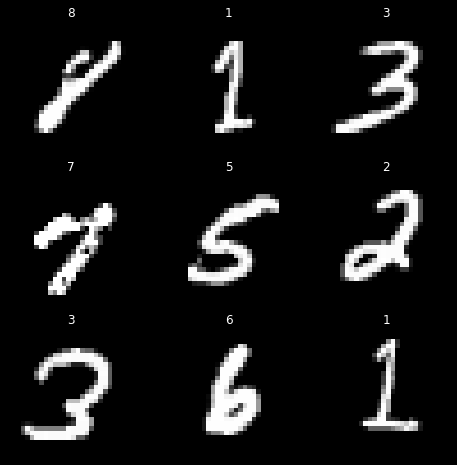

In [ ]:
# plotting sample of dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
#randomly selecting index from dataset
rand_idx = torch.randint(len(mnist_train_data), size=(cols*rows,))
for i, idx in enumerate(rand_idx):
  #unpacking data set for img and label
  img, label = mnist_train_data[idx.item()]
  figure.add_subplot(rows, cols, i+1)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# creating a custom data set for loading image and radom number
class CustomDataSet(Dataset):
  def __init__(self, mnist_dataset):
    self.mnist = mnist_dataset
    self.numbers = torch.randint(10, size=(len(self),))

  def __getitem__(self, index):
    #unpack img and label from mnist
    img, label = self.mnist[index]
    #get number from random number tensor
    number = self.numbers[index]
    #one hot encoding number
    num_onehot = F.one_hot(number, num_classes = 10).squeeze().float()
    #dictionary with input and target
    return {'input': [img.to(device), num_onehot.to(device)], 'target':[label, label + number.item()]}

  def __len__(self):
    return len(self.mnist)

In [ ]:

#instantiating dataset
dataset = CustomDataSet(mnist_train_data)
# NOTE :Basically this contains 60000 dictionary  of 'input':[(1x28X28),(1X10)] i.e image and one hot encoded random number
                                                    # target:[int ,int] i.e label of image and label+random number

#instantiating data loader with batch size 10
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

#data_loader =dataset divded into batches of 10 input 


In [ ]:
#get batch from data leader
batch = next(iter(data_loader))
inputs, targets = batch['input'], batch['target']
print("Image batch {0}, One-hot encoded Number {1}\n\
Handwritten digit label {2}, Sum of number and digit {3}".format(inputs[0].shape, inputs[1].shape, targets[0].shape, targets[1].shape))

Image batch torch.Size([10, 1, 28, 28]), One-hot encoded Number torch.Size([10, 10])
Handwritten digit label torch.Size([10]), Sum of number and digit torch.Size([10])


In [ ]:
# LETS CREATE TRAIN AND TEST LOADER
#STEP 1: Download data 
#STEP 2: pass downloaded data through CustomDataSet
#STEP 3: dataloader
#TRAINLOADER 
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       #transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
mnist_train_data = datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=train_transforms
)
train_dataset = CustomDataSet(mnist_train_data)
train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [ ]:
mnist_test_data = datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=test_transforms
)
test_dataset = CustomDataSet(mnist_test_data)
test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [ ]:
len(train_dataset),len(test_dataset),len(train_data_loader),len(test_data_loader)


(60000, 10000, 235, 40)

In [ ]:
batch = next(iter(test_data_loader))
inputs, targets = batch['input'], batch['target']
print(len(inputs[0]))
print("Image batch {0}, One-hot encoded Number {1}\n\
Handwritten digit label {2}, Sum of number and digit {3}".format(inputs[0].shape, inputs[1].shape, targets[0].shape, targets[1].shape))
print(targets[0][0])
print(inputs[1][0])
print(targets[1][0])


256
Image batch torch.Size([256, 1, 28, 28]), One-hot encoded Number torch.Size([256, 10])
Handwritten digit label torch.Size([256]), Sum of number and digit torch.Size([256])
tensor(2)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor(2)


In [ ]:
class Network1(nn.Module):
  def __init__(self):
      super().__init__()

      #IMAGE 1X1X28 => 1X1X10 
      self.input_block = nn.Sequential(
      #INPUT 28X28X1 >>CONV 3X3X1X16 >>26X26X16
      nn.Conv2d(1, 16, 3, bias=False), 
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.Dropout2d(0.1),


      #INPUT 26X26X16 >>CONV 3X3X16X32 >>24X24X32
      nn.Conv2d(16, 32, 3, bias=False), 
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.Dropout2d(0.1),
      )
        # translation layer

      self.trans1 = nn.Sequential(
      #24X24x32 >>CONV 1X1X32X8 >>24X24X8
      nn.Conv2d(32, 8, 1, bias=False), 
      nn.ReLU(),
      #24X24x8 >>MAXPOOL (2,2) >>12X12X8
      nn.MaxPool2d(2, 2),
      )
      self.conv_block = nn.Sequential(
      #12X12x8 >>CONV 3X3X8X16 PAD=1 >>12X12X16
      nn.Conv2d(8, 16, 3,padding=1, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.Dropout2d(0.1),

      #12X12x16 >>CONV 3X3X16X32 >>10X10X32

      nn.Conv2d(16, 32, 3, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.Dropout2d(0.1),

      )
              # translation layer
      self.trans2 = nn.Sequential(
      #10X10x32 >>CONV 1X1X32X8 >>10X10X8
      nn.Conv2d(32, 8, 1, bias=False), 
      nn.ReLU(),
      #10X10x8 >>MAXPOOL (2,2) >>5X5X8
      nn.MaxPool2d(2, 2),
      )
      self.conv_block2 = nn.Sequential(
      #5X5X8 >>CONV 3X3X8X16 PAD=1 >>5X5X16
      nn.Conv2d(8, 16, 3,padding=1,bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.Dropout2d(0.1),  
      #5X5X16 >>CONV 3X3X8X32 PAD=0 >>3X3X32
      nn.Conv2d(16, 32, 3,bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.Dropout2d(0.1),

      )


      self.avg_pool = nn.Sequential(
      #3X3X32 >>CONV 1X1X32X10  >>3X3X10
      nn.Conv2d(32, 10, 1, bias=False),
      #3X3X10 >>AVG pool(3X3) >>1X1X10
      nn.AvgPool2d(3))

      ####################
      #TEXT DATA 
      ###################  
      #Random number block
      #1X1X10  =>1X1X64
      self.fc1 = nn.Linear(10, 64)
      
      #concated fc1 and flatten conv2
      self.fc2 = nn.Linear(in_features=32*3*3 + 64, out_features=128)
      self.fc3 = nn.Linear(in_features=128, out_features=64)
      #self.fc4 = nn.Linear(in_features=256, out_features=64)

      #output layers
      self.out1 = nn.Linear(in_features=64, out_features=10)
      self.out2 = nn.Linear(in_features=64, out_features=19)

  def forward(self, t):
      #unpacking image and numbers
      images, numbers  = t
      #IMAGE 
      x = self.input_block(images)
      x = self.trans1(x)
      x = self.conv_block(x)
      x = self.trans2(x)
      x = self.conv_block2(x)
      x = x.reshape(-1, 32 * 3 * 3)
      #x = self.avg_pool(x)
      #x = x.view(-1, 10)
      #NUMBERS

      # sending random number to FC1
      t1=x
      t2 = self.fc1(numbers)
      t2 = F.relu(t2)

      # concatination of t1 and t2
      t = torch.cat((t1, t2), 1)

      # Propagating concatinated tensor to fully connected layers
      t = self.fc2(t)
      t = F.relu(t)

      t = self.fc3(t)
      t = F.relu(t)

      # t = self.fc4(t)
      # t = F.relu(t)

      # Out1 Image Digit Prediction
      o1 = self.out1(t)
      o1 = F.softmax(o1, dim=1)

      # Out2 Sum prediction
      o2 = self.out2(t)
      o2 = F.softmax(o2, dim=1)

      return o1, o2

In [ ]:
model = Network1().to(device)
print(model)

Network1(
  (input_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.1, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=Fa

In [ ]:
#computing loss function for two softmax outputs
def loss_function(outputs, t1, t2):
  #unpacking outputs
  o1, o2 = outputs
  #computing cross entropy loss
  l1=torch.nn.functional.cross_entropy(o1,t1)
  l2=torch.nn.functional.cross_entropy(o2,t2)
  #l1 = nn.CrossEntropyLoss()(o1, t1)
  #l2 = nn.CrossEntropyLoss()(o2, t2)

  #computing average loss
  return l1+l2

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc_image = []
train_acc_adder = []
test_acc = []



def train(model, device, train_loader, optimizer, epoch):
  #model.train()
  #pbar = tqdm(train_loader)
  correct = 0
  digits_correct=0
  sums_correct=0
  processed = 0
  #for batch_idx, batch in enumerate(pbar):
  for batch in train_loader:
    # get samples
    inputs, targets = batch['input'], batch['target']
    t1, t2 = targets[0].to(device), targets[1].to(device)
    #data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    preds = model(inputs)
    loss = loss_function(preds, t1, t2)


    # Calculate loss
    #loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    digits_correct += preds[0].argmax(1).eq(t1).sum().item()
    sums_correct += preds[1].argmax(1).eq(t2).sum().item()


    processed += len(inputs[0])
    #print(processed)
    #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx}/{len(train_loader)} image_accuracy={100*digits_correct/processed:0.2f} adder_accuracy={100*sums_correct/processed:0.2f}')
    train_acc_image.append(100*digits_correct/processed)
    train_acc_adder.append(100*sums_correct/processed)
    #tqdm._instances.clear()
  # print("*****EPOCH SUMMARY IN TRAIN *****")
  # print("Epoch :", epoch+1)
  # print("Total images processed for the epoch", processed)
  # print("Images correct:",digits_correct)
  # print("Addition correct:",sums_correct)
  # print("Loss at the end of epoch",train_losses[-1].item())
  # print("Training Accuracy for image ",100*digits_correct/processed)
  # print("Training Accuracy for Addition ",100*sums_correct/processed)
  print("[TRAIN]: => loss {0}, total correct digits {1}, total correct sums {2} ,[image_accuracy]={3} , [adder_accuracy]={4} ".format(train_losses[-1].item(), digits_correct,sums_correct,
                                                                                                                                   round((100*digits_correct/processed),2),round((100*sums_correct/processed),2)))
  return train_losses[-1].item(),round((100*digits_correct/processed),2),round((100*sums_correct/processed),2)
  



def test(model, device, test_loader):
    model.eval()
    digits_correct = 0
    sums_correct = 0
    processed = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch['input'], batch['target']
            t1, t2 = targets[0].to(device), targets[1].to(device)
            preds = model(inputs)
            loss = loss_function(preds, t1, t2)
            test_losses.append(loss)
            digits_correct += preds[0].argmax(1).eq(t1).sum().item()
            sums_correct += preds[1].argmax(1).eq(t2).sum().item()
            processed += len(inputs[0])
    # print("*****EPOCH SUMMARY IN TEST *****")
    # print("Images correct:",digits_correct)
    # print("Addition correct:",sums_correct)
    # print("Loss at the end of epoch",test_losses[-1].item())
    # print("Total images processed for the epoch",processed) 
    # print("Testing Accuracy for image ",100*digits_correct/processed)
    # print("Testing  Accuracy for Addition ",100*sums_correct/processed) 
    print("[TEST] : => loss {0}, total correct digits {1}, total correct sums {2} ,[image_accuracy]={3} , [adder_accuracy]={4} ".format(test_losses[-1].item(), digits_correct,sums_correct,
                                                                                                                           round((100*digits_correct/processed),2),round((100*sums_correct/processed),2)))
    return test_losses[-1].item(),round((100*digits_correct/processed),2),round((100*sums_correct/processed),2)





In [ ]:
model = Network1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimiser = optim.Adam(model.parameters(), lr=0.01)
EPOCHS = 5
train_loss_per_epoch=[]
train_image_acc_per_epoch=[]
train_adder_accuracy_per_epoch=[]
test_loss_per_epoch=[]
test_image_acc_per_epoch=[]
test_adder_accuracy_per_epoch=[]
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_loss,train_image_accuracy,train_adder_accuracy=train(model, device, train_data_loader, optimizer, epoch)
    train_loss_per_epoch.append(train_epoch_loss)
    train_image_acc_per_epoch.append(train_image_accuracy)
    train_adder_accuracy_per_epoch.append(train_adder_accuracy)

    test_epoch_loss,test_image_accuracy,test_adder_accuracy=test(model, device, test_data_loader)
    test_loss_per_epoch.append(test_epoch_loss)
    test_image_acc_per_epoch.append(test_image_accuracy)
    test_adder_accuracy_per_epoch.append(test_adder_accuracy)

EPOCH: 0
[TRAIN]: => loss 5.244495391845703, total correct digits 7193, total correct sums 4597 ,[image_accuracy]=11.99 , [adder_accuracy]=7.66 
[TEST] : => loss 5.239509582519531, total correct digits 1679, total correct sums 832 ,[image_accuracy]=16.79 , [adder_accuracy]=8.32 
EPOCH: 1
[TRAIN]: => loss 5.2393269538879395, total correct digits 11455, total correct sums 4956 ,[image_accuracy]=19.09 , [adder_accuracy]=8.26 
[TEST] : => loss 5.242795944213867, total correct digits 2208, total correct sums 927 ,[image_accuracy]=22.08 , [adder_accuracy]=9.27 
EPOCH: 2
[TRAIN]: => loss 4.824916839599609, total correct digits 15437, total correct sums 5451 ,[image_accuracy]=25.73 , [adder_accuracy]=9.09 
[TEST] : => loss 4.738735675811768, total correct digits 5340, total correct sums 915 ,[image_accuracy]=53.4 , [adder_accuracy]=9.15 
EPOCH: 3
[TRAIN]: => loss 4.5875749588012695, total correct digits 40876, total correct sums 6006 ,[image_accuracy]=68.13 , [adder_accuracy]=10.01 
[TEST] : =

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(3,2,figsize=(15,10))
axs[0, 0].plot(train_loss_per_epoch)
axs[0, 0].set_title("Training Loss")
axs[0, 1].plot(train_loss_per_epoch)
axs[0, 1].set_title("Test Loss")
axs[1, 0].plot(train_image_acc_per_epoch)
axs[1, 0].set_title("Training Accuracy Image")
axs[1, 1].plot(test_image_acc_per_epoch)
axs[1, 1].set_title("Test Accuracy Image")
axs[2, 0].plot(train_adder_accuracy_per_epoch)
axs[2, 0].set_title("Training Accuracy Image")
axs[2, 1].plot(test_adder_accuracy_per_epoch)
axs[2, 1].set_title("Test Accuracy Image")
plt.show()